# SRC physics

__Author:__ A. J. Tropiano [tropiano.4@osu.edu]<br/>
__Date:__ April 9, 2021

Generates SRC physics figures based on this paper: A. J. Tropiano, S. K. Bogner, and R. J. Furnstahl, [Phys. Rev. C __104__, 034311 (2021)](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.104.034311).

_Last update:_ July 27, 2022

__To-do list:__
* Finish functions:
7. Data
11. Partial wave contributions table
12. Bar chart figure
* Add markdown to cells in section.
* Add docstrings to functions.
* Check imports.

In [1]:
# Python imports
from itertools import chain
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# Imports from A.T. codes
from scripts.figures import (
    set_rc_parameters, line_styles, xkcd_colors, label_kvnn, label_lambda,
    label_nucleus
)
from scripts.integration import (
    unattach_weights_from_matrix, unattach_weights_from_vector
)
from scripts.momentum_distributions import MomentumDistribution
from scripts.momentum_projection_operator import momentum_projection_operator
from scripts.potentials import Potential
from scripts.srg import get_transformation
from scripts.tools import find_index, replace_periods
from scripts.wave_function import wave_function

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
# Save figures in the following directory
figures_directory = '../figures/src/'

# Directory for VMC data
vmc_directory = '../data/vmc/momentum_distributions'

# Directory for experimental a_2 values
exp_directory = '../data/exp'

## Plotting functions

In [ ]:
def srg_transformation_ratio(
        k_0, kvnns, lamb, kmax=15.0, kmid=3.0, ntot=120, x_limits=(0,4),
        y_limits=(1e0,1e3), xlabel_size=16, ylabel_size=16, ratio_label=True,
        save=False):
    """
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # --- Get data --- #
    # Loop over kvnns
    for i, kvnn in enumerate(kvnns):
        
        # Store |U(k_0, q)|^2 in dictionary with channel as key
        d = {}
        
        # Loop over 3S1 and 1S0:
        for channel in ('3S1', '1S0'):
            
            # Initialize potential object and get its momentum mesh
            potential = Potential(kvnn, channel, kmax, kmid, ntot)
            q_array, q_weights = potential.load_mesh()
            
            # Get index of k_0 in k_array
            k0_index = find_index(k_0, q_array)
        
            # Get initial and evolved Hamiltonians [MeV]
            H_initial = potential.load_hamiltonian()
            H_evolved = potential.load_hamiltonian('srg', 'Wegner', lamb)
            
            # Calculate unitary transformation [unitless]
            U_matrix_weights = get_transformation(H_initial, H_evolved)
        
            # Divide out integration weights [fm^3] and add to dictionary
            d[channel] = unattach_weights_from_matrix(
                q_array, q_weights, U_matrix_weights,
                coupled_channel=potential.coupled_channel_bool
            )
            
        # Calculate |U(k_0, q)_{3S1}|^2
        numerator_array = (
            d['3S1'][k0_index, :ntot]*d['3S1'].T[:ntot, k0_index]
            + d['3S1'][k0_index, ntot:]*d['3S1'].T[ntot:, k0_index]
        )
        
        # Calculate |U(k_0, q)_{1S0}|^2
        denominator_array = (d['1S0'][k0_index, :ntot]
                             * d['1S0'].T[:ntot, k0_index])
        
        # Take ratio of 3S1 / 1S0
        ratio_array = numerator_array / denominator_array
            
        # --- Set data labels --- #
        curve_color = xkcd_colors(i+1)  # Skip xkcd:black
        curve_label = label_kvnn(kvnn)  # Labels the potential
        
        # --- Plot --- #
        ax.semilogy(q_array, ratio_array, color=curve_color,
                    label=curve_label, linestyle='solid', linewidth=2.0)

    # --- Plot final features --- #
    # Shade gray from 0 to \lambda value on plot
    ax.fill_betweenx(y_limits, 0.0, lamb, alpha=0.2, edgecolor='xkcd:grey',
                     facecolor='xkcd:grey')

    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$q$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel(r"$|U_{\lambda}(k_0,q)|^2$" + ' ratio',
                  fontsize=ylabel_size)
    
    # --- Legend --- #
    ax.legend(loc='lower left', fontsize=13, frameon=True)
    
    # --- Additional labels --- #
    if ratio_label:  # Label 3S1/1S0
        ax.add_artist(
            AnchoredText(r'$\frac{^3{\rm S}_1}{^{1}{\rm S}_0}$',
                         loc='upper right', prop=dict(size=24), frameon=False)
        )

    # --- Save file --- #
    if save:
        file_name = f'srg_transformation_ratio_k_0_{k_0}_kvnns'
        for ikvnn in kvnns:
            file_name += f'_{ikvnn}'
        file_name += f'_lamb_{lamb}_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}'
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [ ]:
def interleave(*iters):
    """
    Take a set of lists of the same length and interleave them.
    """
    return list(chain(*zip(*iters)))

In [ ]:
# temp.

    def n_lambda_exact(self, q, contributions='total'):
        """
        Computes the exact deuteron momentum distribution using the wave
        function from the input Hamiltonian. Note, set interp = False to use
        this function.

        Parameters
        ----------
        q : float
            Momentum value [fm^-1].
        contributions : str, optional
            Option to return different contributions to the momentum
            distribution.
            1. Default is 'total' which only returns the total momentum
               distribution.
            2. Specify 'q_contributions' for I, \delta U, and 
               \delta U \delta U^\dagger along with the total.
            3. Specify 'partial_wave_ratio' for the ratio of 3S1-3S1 to full
               3S1-3D1 along with the absolute total.

        Returns
        -------
        output : float or tuple
            Pair momentum distribution [fm^3] evaluated at momentum q
            [fm^-1]. (Note, this function will return a tuple of floats if
            contributions is not 'total'.)

        """

        # Load deuteron wave function and delta_U_matrix (both unitless)
        psi_vector = self.psi
        delta_U_matrix = self.delta_U_matrix
        
        # Load bare momentum projection operator [fm^3]
        bare_operator = momentum_projection_operator(q, self.k_array,
                        self.k_weights, '3S1', smeared=False)
        
        # Term 1: 1 * n(q) * 1
        term_1 = psi_vector.T @ bare_operator @ psi_vector
        
        # Term 2: \deltaU * n(q) * 1
        term_deltaU = psi_vector.T @ delta_U_matrix @ bare_operator @ \
                      psi_vector
        
        # Term 3: 1 * n(q) * \deltaU^\dagger = Term 2
        term_deltaU *= 2
        
        # High-q term: \deltaU * n(q) * \deltaU^\dagger
        term_deltaU2 = psi_vector.T @ delta_U_matrix @ bare_operator @ \
                        delta_U_matrix.T @ psi_vector
                       
        if contributions == 'partial_wave_ratio':
            
            # Length of q_array
            ntot = self.ntot
            
            # 3S1-3S1 only
            numerator = abs( psi_vector.T[:ntot] @ ( \
                                 delta_U_matrix[:ntot, :ntot] @ \
                                 bare_operator[:ntot, :ntot] @ \
                                 delta_U_matrix.T[:ntot, :ntot] +
                                 delta_U_matrix[:ntot, ntot:] @ \
                                 bare_operator[ntot:, ntot:] @ \
                                 delta_U_matrix.T[ntot:, :ntot] ) @ \
                             psi_vector[:ntot] )
                        
            # Full 3S1-3D1 taking absolute values 
            denominator = numerator + \
                          abs( psi_vector.T[:ntot] @ ( \
                                   delta_U_matrix[:ntot, :ntot] @ \
                                   bare_operator[:ntot, :ntot] @ \
                                   delta_U_matrix.T[:ntot, ntot:] +
                                   delta_U_matrix[:ntot, ntot:] @ \
                                   bare_operator[ntot:, ntot:] @ \
                                   delta_U_matrix.T[ntot:, ntot:] ) @ \
                               psi_vector[ntot:] ) + \
                          abs( psi_vector.T[ntot:] @ ( \
                                   delta_U_matrix[ntot:, :ntot] @ \
                                   bare_operator[:ntot, :ntot] @ \
                                   delta_U_matrix.T[:ntot, :ntot] +
                                   delta_U_matrix[ntot:, ntot:] @ \
                                   bare_operator[ntot:, ntot:] @ \
                                   delta_U_matrix.T[ntot:, :ntot] ) @ \
                               psi_vector[:ntot] ) + \
                          abs( psi_vector.T[ntot:] @ ( \
                                   delta_U_matrix[ntot:, :ntot] @ \
                                   bare_operator[:ntot, :ntot] @ \
                                   delta_U_matrix.T[:ntot, ntot:] +
                                   delta_U_matrix[ntot:, ntot:] @ \
                                   bare_operator[ntot:, ntot:] @ \
                                   delta_U_matrix.T[ntot:, ntot:] ) @ \
                               psi_vector[ntot:] )
                                   
        # Add up each term for total
        total = term_1 + term_deltaU + term_deltaU2

        # Return contributions and total or just total
        if contributions == 'q_contributions':
            return total, term_1, term_deltaU, term_deltaU2
        elif contributions == 'partial_wave_ratio':
            return total, numerator/denominator
        else: # Default
            return total

In [ ]:
def deuteron_channel_contributions_bar_chart():
    """
    """
    return None

In [ ]:
def deuteron_momentum_distribution_contributions(
        kvnn, lamb, kmax=15.0, kmid=3.0, ntot=120, number_of_curves=4,
        x_limits=(0, 4), y_limits=(1e-5, 1e3), xlabel_size=16, ylabel_size=16,
        save=False):
    """
    """
    
    # Make sure the number of curves makes sense (1 to 4)
    if not (number_of_curves in range(1, 5)):
        raise RuntimeError(
            'Invalid number of curves. Must specify an integer from 1 to 4.'
        )
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # --- Get data --- #
    # Channel is 3S1-3D1 for deuteron
    channel = '3S1'

    # Initialize potential object and get its momentum mesh
    potential = Potential(kvnn, channel, kmax, kmid, ntot)
    q_array, q_weights = potential.load_mesh()
    
    # Get initial and evolved Hamiltonians [MeV]
    H_initial = potential.load_hamiltonian()
    H_evolved = potential.load_hamiltonian('srg', 'Wegner', lamb)
            
    # Calculate unitary transformation [unitless]
    U_matrix = get_transformation(H_initial, H_evolved)
    
    # Isolate the two-body piece \delta U [unitless]
    I_matrix = np.eye(2*ntot, 2*ntot)
    delta_U_matrix = U_matrix - I_matrix
    
    # Get deuteron wave functions [unitless]
    psi_d_initial_weights = wave_function(H_initial, eps=-2.22)
    psi_d_evolved_weights = wave_function(H_initial, eps=-2.22,
                                          U_matrix=U_matrix)
    
    # High resolution momentum distribution [fm^3]
    psi_d_initial = unattach_weights_from_vector(
        q_array, q_weights, psi_d_initial_weights, coupled_channel=True
    )
    n_d_total_array = psi_d_initial[:ntot]**2 + psi_d_initial[ntot:]**2
    
    # Initialize contributions to the deuteron momentum distribution
    n_d_1_array = np.zeros_like(q_array)
    n_d_deltaU_array = np.zeros_like(q_array)
    n_d_deltaU2_array = np.zeros_like(q_array)
    
    # Loop over momenta and calculate evolved momentum projection operator
    # at each q, then calculate contributions to |\psi_d(q)|^2
    for i, q in enumerate(q_array):
        
        # Compute the evolved momentum projection operator [fm^3]
        mpo_operator = momentum_projection_operator(
            q, q_array, q_weights, coupled=True, smeared=False
        )

        # Term 1: 1 * n(q) * 1
        n_d_1_array[i] = (psi_d_evolved_weights.T @ mpo_operator
                          @ psi_d_evolved_weights)
        
        # Term 2: \deltaU * n(q) * 1 (multiply by 2 since Term 3 = Term 2)
        n_d_deltaU_array[i] = 2 * (psi_d_evolved_weights.T @ delta_U_matrix
                                   @ mpo_operator @ psi_d_evolved_weights)
        
        # High-q term: \deltaU * n(q) * \deltaU^\dagger
        n_d_deltaU2_array[i] = (
            psi_d_evolved_weights.T @ delta_U_matrix @ mpo_operator
            @ delta_U_matrix.T @ psi_d_evolved_weights
        )
    
    # --- Plot --- #
    # Total deuteron wave function (high resolution)
    ax.semilogy(q_array, n_d_total_array, color='xkcd:black',
                label="High res.", linestyle='solid', linewidth=2.0)
    
    # Plot 1 term
    if number_of_curves > 1:
        ax.semilogy(q_array, n_d_1_array, color='xkcd:blue', label="1",
                    linestyle='dotted', linewidth=2.0)
        
    # Plot \delta U term (take absolute value!)
    if number_of_curves > 2:
        ax.semilogy(q_array, abs(n_d_deltaU_array), color='xkcd:green',
                    label=r"$|\delta U|$", linestyle='dashed', linewidth=2.0)
        
    # Plot \delta U^2 term
    if number_of_curves > 3:
        ax.semilogy(
            q_array, n_d_deltaU2_array, color='xkcd:red',
            label=r'$\delta U \delta U^{\dagger}$', linestyle='dashdot',
            linewidth=2.0
        )

    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$q$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel(r"$n_{\lambda}^d(q)$" + " [fm" + r"$^3$" + "]",
                  fontsize=ylabel_size)
    
    # --- Legend --- #
    ax.legend(loc='upper right', fontsize=14, frameon=False)
    
    # --- Save file --- #
    if save:
        file_name = ('deuteron_momentum_distribution_contributions_kvnn_'
                     f'{kvnn}_lamb_{lamb}_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}'
                     f'_number_of_curves_{number_of_curves}')
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [ ]:
def delU_factorization_ratios(
        k_0, k_i_values, kvnn, channel, lamb, kmax=15.0, kmid=3.0, ntot=120,
        x_limits=(0, 5), y_limits=(1e-2, 1e2), xlabel_size=16, ylabel_size=16,
        k0_lamb_label=True, save=False):
    """
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # --- Get data --- #
    # Initialize potential object and get its momentum mesh
    potential = Potential(kvnn, channel, kmax, kmid, ntot)
    q_array, q_weights = potential.load_mesh()
    
    # Get initial and evolved Hamiltonians [MeV]
    H_initial = potential.load_hamiltonian()
    H_evolved = potential.load_hamiltonian('srg', 'Wegner', lamb)
            
    # Calculate unitary transformation [unitless]
    U_matrix_unitless = get_transformation(H_initial, H_evolved)
    
    # Isolate the two-body piece \delta U [unitless]
    if potential.coupled_channel_bool:
        I_matrix_unitless = np.eye(2*ntot, 2*ntot)
    else:
        I_matrix_unitless = np.eye(ntot, ntot)
    delta_U_matrix_unitless = U_matrix_unitless - I_matrix_unitless
    
    # Divide out integration factor
    delta_U_matrix = unattach_weights_from_matrix(
        q_array, q_weights, delta_U_matrix_unitless,
        coupled_channel=potential.coupled_channel_bool
    )
    
    # Calculate \delta U(k_0, q) \delta U^{\dagger}(q, k_0) array
    k0_index = find_index(k_0, q_array)
    # Single channel (do not include coupled parts for coupled-channel)
    denominator_array = (delta_U_matrix[k0_index, :ntot] 
                         * delta_U_matrix.T[:ntot, k0_index])
    
    # Loop over k_i
    for i, k_i in enumerate(k_i_values):
    
        # Calculate \delta U(k_i, q) \delta U^{\dagger}(q, k_i) array
        ki_index = find_index(k_i, q_array)
        # Single channel (do not include coupled parts for coupled-channel)
        numerator_array = (delta_U_matrix[ki_index, :ntot] 
                           * delta_U_matrix.T[:ntot, ki_index])
        
        # Take absolute value of ratio
        ratio_array = abs(numerator_array/denominator_array)

        # --- Set data labels --- #
        curve_color = xkcd_colors(i)
        curve_style = line_styles(i)
        curve_label = rf'$k_{i+1}={k_i}$' + ' fm' + r'$^{-1}$'

        # --- Plot --- #
        ax.semilogy(q_array, ratio_array, color=curve_color,
                    label=curve_label, linestyle=curve_style, linewidth=2.0)

    # --- Plot final features --- #
    # Shade gray from 0 to \lambda value on plot
    ax.fill_betweenx(y_limits, 0.0, lamb, alpha=0.3, edgecolor='xkcd:grey',
                     facecolor='xkcd:grey')

    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$q$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel(r"$\delta U \delta U^{\dagger}(k, q)$" + " ratio",
                  fontsize=ylabel_size)
    
    # --- Legend --- #
    ax.legend(loc='upper right', fontsize=11, frameon=False)
    
    # --- Additional labels --- #
    if k0_lamb_label:  # Label k_0 and \lambda
        k_0_label = rf'$k_0={k_0}$' + ' fm' + r'$^{-1}$'
        lambda_label = label_lambda(lamb)
        ax.add_artist(
            AnchoredText(k_0_label + '\n' + lambda_label, loc='lower right',
                         prop=dict(size=11), frameon=False)
        )

    # --- Save file --- #
    if save:
        file_name = f'delU_factorization_ratios_k0_{k_0}_ki'
        for k_i in k_i_values:
            file_name += f'_{k_i}'
        file_name += (f'_{kvnn}_{channel}_lamb_{lamb}_kmax_{kmax}_kmid_{kmid}'
                      f'_ntot_{ntot}')
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [5]:
def proton_momentum_distribution(
        nucleus, kvnn, channels=('1S0','3S1'), kmax=15.0, kmid=3.0, ntot=120,
        generator='Wegner', lamb=1.35, density='SLy4', x_limits=(0,6),
        y_limits=(4e-4,3e2), xlabel_size=16, ylabel_size=16,
        exclude_low_q=True, save=False):
    """
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # Set y-axis to log scale
    ax.set_yscale('log')
    
    # --- Get data --- #
    # Unpack nucleus information
    nucleus_name, Z, N = nucleus
    
    # Initialize momentum distribution object
    md = MomentumDistribution(kvnn, kmax, kmid, ntot)
    
    q_array, n_p_array = md.get_single_nucleon_momentum_distribution(
        'proton', nucleus_name, density, channels, generator, lamb
    )
    
    # Only show n(q) at q > 0.6 fm^-1
    if exclude_low_q:
        q_min_index = find_index(0.6, q_array)
        q_array = q_array[q_min_index:]
        n_p_array = n_p_array[q_min_index:]

    # --- Plot --- #
    ax.plot(q_array, n_p_array/Z, color='xkcd:red',
            label=label_nucleus(nucleus_name), linewidth=2.0)

    # --- Plot final features --- #
    # Add VMC data with error bars
    try:
        vmc_data = np.loadtxt(vmc_directory + '/'
                              + f'{nucleus_name}_single_nucleon.txt')
        q_array_vmc = vmc_data[:, 0] # fm^-1
        n_p_array_vmc = vmc_data[:, 1]
        error_bars_array_vmc = vmc_data[:, 2]
        ax.errorbar(q_array_vmc, n_p_array_vmc/Z, yerr=error_bars_array_vmc/Z,
                    color='xkcd:black', label='VMC', linestyle='', marker='.')
    except OSError:  # No VMC data for this nucleus
        print(f"There is no VMC data for {nucleus_name}.")
    
    # Shade gray from 0 to \lambda value on plot
    ax.fill_betweenx(y_limits, 0.0, lamb, alpha=0.3, edgecolor='xkcd:grey',
                     facecolor='xkcd:grey')

    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$q$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel("proton "+r"$n_{\lambda}^A(q)/Z$"+" [fm"+r"$^3$"+"]",
                  fontsize=ylabel_size)
    
    # --- Legend --- #
    ax.legend(loc='upper right', fontsize=16, frameon=False)
    
    # --- Save file --- #
    if save:
        file_name = (f'proton_momentum_distribution_{nucleus_name}_kvnn'
                     f'_{kvnn}')
        for ichannel in channels:
            file_name += f'_{ichannel}'
        file_name += (f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}_lamb'
                      f'_{lamb}_{density}')
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [9]:
def multiple_proton_momentum_distributions(
        nuclei, kvnn, channels=('1S0','3S1'), kmax=15.0, kmid=3.0, ntot=120,
        generator='Wegner', lamb=1.35, density='SLy4', x_limits=(0,6),
        y_limits=(4e-4,3e2), xlabel_size=16, ylabel_size=16,
        exclude_low_q=True, save=False):
    """
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    col_number = len(nuclei)
    f, axs = plt.subplots(1, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number,4))
    
    # --- Get data --- #
    # Initialize momentum distribution object
    md = MomentumDistribution(kvnn, kmax, kmid, ntot)
    
    # Loop over nuclei
    for i, nucleus in enumerate(nuclei):
        
        # Unpack nucleus information
        nucleus_name, Z, N = nucleus
    
        q_array, n_p_array = md.get_single_nucleon_momentum_distribution(
            'proton', nucleus_name, density, channels, generator, lamb
        )
    
        # Only show n(q) at q > 0.6 fm^-1
        if exclude_low_q:
            q_min_index = find_index(0.6, q_array)
            q_array = q_array[q_min_index:]
            n_p_array = n_p_array[q_min_index:]
        
        # --- Plot --- #
        # Set y-axis to log scale
        axs[i].set_yscale('log')
        
        axs[i].plot(q_array, n_p_array/Z, color='xkcd:red',
                    label=label_nucleus(nucleus_name), linewidth=2.0)

        # --- Plot final features --- #
        # Add VMC data with error bars
        try:
            vmc_data = np.loadtxt(vmc_directory + '/'
                                  + f'{nucleus_name}_single_nucleon.txt')
            q_array_vmc = vmc_data[:, 0] # fm^-1
            n_p_array_vmc = vmc_data[:, 1]
            error_bars_array_vmc = vmc_data[:, 2]
            axs[i].errorbar(
                q_array_vmc, n_p_array_vmc/Z, yerr=error_bars_array_vmc/Z,
                color='xkcd:black', label='VMC', linestyle='', marker='.'
            )
        except OSError:  # No VMC data for this nucleus
            print(f"There is no VMC data for {nucleus_name}.")
    
        # Shade gray from 0 to \lambda value on plot
        axs[i].fill_betweenx(y_limits, 0.0, lamb, alpha=0.3,
                             edgecolor='xkcd:grey', facecolor='xkcd:grey')

        # --- Axes limits --- #
        axs[i].set_xlim(x_limits)
        axs[i].set_ylim(y_limits)  

        # --- Axes labels --- #
        axs[i].set_xlabel("$q$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    
    # Only label the far left y-axis
    axs[0].set_ylabel("proton "+r"$n_{\lambda}^A(q)/Z$"+" [fm"+r"$^3$"+"]",
                      fontsize=ylabel_size)
    
    # --- Adjust axes --- #
    # Amount of white space in-between sub-plots
    f.subplots_adjust(wspace=0.05)
    
    # --- Legend --- #
    for i in range(col_number):
        axs[i].legend(loc='upper right', fontsize=14, frameon=False)
    
    # --- Save file --- #
    if save:
        file_name = 'proton_momentum_distributions'
        for inucleus in nuclei:
            file_name += f'_{inucleus[0]}'
        file_name += f'_kvnn_{kvnn}'
        for ichannel in channels:
            file_name += f'_{ichannel}'
        file_name += (f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}_lamb'
                      f'_{lamb}_{density}')
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [ ]:
def proton_momentum_distribution_tails(
        nuclei, kvnn, channels=('1S0','3S1'), kmax=15.0, kmid=3.0, ntot=120,
        generator='Wegner', lamb=1.35, density='SLy4', x_limits=(1.5,6.0),
        y_limits=(1e-3,1e0), xlabel_size=16, ylabel_size=16, save=False):
    """
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # --- Get data --- #
    # Loop over nuclei
    for i, nucleus in enumerate(nuclei):
        
        # ...
        
        # --- Set data labels --- #
        curve_color = xkcd_colors(i)
        curve_style = line_styles(i)
        curve_label = label_nucleus(nucleus_name)

        # --- Plot --- #
        ax.semilogy(q_array, n_p_array/Z, color=curve_color,
                    linestyle=curve_style, label=curve_label, linewidth=2.0)
    
    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$q$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel("proton "+r"$n_{\lambda}^A(q)/Z$"+" [fm"+r"$^3$"+"]",
                  fontsize=ylabel_size)
    
    # --- Legend --- #
    ax.legend(loc='upper right', fontsize=13, frameon=False)
    
    # --- Save file --- #
    if save:
        file_name = f'proton_momentum_distribution_tails'
        for inucleus in nuclei:
            file_name += f'_{inucleus[0]}'
        file_name += f'_kvnn_{kvnn}'
        for ichannel in channels:
            file_name += f'_{ichannel}'
        file_name += (f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}_lamb'
                      f'_{lamb}_{density}')
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [ ]:
def snmd_partial_wave_contributions(
        nucleon, nuclei, kvnn, channels=('1S0','3S1'), kmax=15.0, kmid=3.0,
        ntot=120, generator='Wegner', lamb=1.35, density='SLy4'):
    """
    """
    return None

In [ ]:
def proton_over_neutron_pmd_ratios(
        nuclei, kvnn, channels=('1S0','3S1'), kmax=15.0, kmid=3.0,
        ntot=120, generator='Wegner', lamb=1.35, density='SLy4',
        x_limits=(1.5,4), y_limits=(0.82,1.15), xlabel_size=16,
        ylabel_size=16, ratio_label=True, save=False):
    """
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # --- Get data --- #
    # Loop over nuclei
    for i, nucleus in enumerate(nuclei):
        
        # ...
        
        # --- Set data labels --- #
        curve_color = xkcd_colors(i)
        curve_style = line_styles(i)
        curve_label = label_nucleus(nucleus_name)

        # --- Plot --- #
        ax.plot(q_array, ratio_array, color=curve_color,
                linestyle=curve_style, label=curve_label, linewidth=2.0)
    
    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$q$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel(r"$n_{\lambda}^A(q,Q=0)$" + " ratio", fontsize=ylabel_size)
    
    # --- Legend --- #
    ax.legend(loc='upper right', fontsize=12, frameon=False, ncol=2)
    
    # --- Additional labels --- #
    if ratio_label:  # Label (pp+pn)/(nn+np)
        ax.add_artist(
            AnchoredText(r'$\frac{pp+pn}{nn+np}$', loc='lower left',
                         prop=dict(size=24), frameon=False)
        )
    
    # --- Save file --- #
    if save:
        file_name = 'proton_over_neutron_pmd_ratios'
        for inucleus in nuclei:
            file_name += f'_{inucleus[0]}'
        file_name += f'_kvnn_{kvnn}'
        for ichannel in channels:
            file_name += f'_{ichannel}'
        file_name += (f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}_lamb'
                      f'_{lamb}_{density}')
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [ ]:
def pp_over_pn_pmd_ratios(
        nuclei, kvnn, channels=('1S0','3S1'), kmax=15.0, kmid=3.0,
        ntot=120, generator='Wegner', lamb=1.35, density='SLy4',
        x_limits=(1.5,4), y_limits=(-0.01,0.25), xlabel_size=16,
        ylabel_size=16, ratio_label=True, save=False):
    """
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # --- Get data --- #
    # Loop over nuclei
    for i, nucleus in enumerate(nuclei):
        
        # ...
        
        # --- Set data labels --- #
        curve_color = xkcd_colors(i)
        curve_style = line_styles(i)
        curve_label = label_nucleus(nucleus_name)

        # --- Plot --- #
        ax.plot(q_array, ratio_array, color=curve_color,
                linestyle=curve_style, label=curve_label, linewidth=2.0)
    
    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$q$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel(r"$n_{\lambda}^A(q,Q=0)$" + " ratio", fontsize=ylabel_size)
    
    # --- Legend --- #
    ax.legend(loc='upper left', fontsize=14, frameon=False)
    
    # --- Additional labels --- #
    if ratio_label:  # Label pp/(pn+np)
        ax.add_artist(
            AnchoredText(r'$\frac{pp}{pn+np}$', loc='upper right',
                         prop=dict(size=25), frameon=False)
        )
    
    # --- Save file --- #
    if save:
        file_name = 'pp_over_pn_pmd_ratios'
        for inucleus in nuclei:
            file_name += f'_{inucleus[0]}'
        file_name += f'_kvnn_{kvnn}'
        for ichannel in channels:
            file_name += f'_{ichannel}'
        file_name += (f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}_lamb'
                      f'_{lamb}_{density}')
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [ ]:
def src_scaling_factors(
        kvnn, lamb, channels=('1S0','3S1'), kmax=15.0, kmid=3.0, ntot=120,
        generator='Wegner', x_limits=(3e0,3e2),
        y_limits=(0.0, 6.5), xlabel_size=16, ylabel_size=16,
        lambda_label=True, save=False):
    """
    Note, this function automatically uses SLy4 and Gogny densities.
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # Set log-scale on x-axis
    ax.set_xscale('log')
    
    # --- Get data --- #
    densities = ('SLy4', 'Gogny')
    d['SLy4'] = ()
    d['Gogny'] = ()
    
    # Loop densities first
    for i, density in enumerate(densities):
        
        nuclei = d[density]
        
        for j, nucleus in enumerate(nuclei):
        
            # ...
            # Create an A_array and a2_array
            
        # --- Set data labels --- #    
        
        # Marker color set by density (experiment is black)
        marker_color = xkcd_color(i+1)  # Skip black
        
        # Off-set x-axis locations slightly so the points are more visible
        if i == 0:
            offset = 1.02
        else:
            offset = 0.98

        # --- Plot --- #
        ax.errorbar(
            offset*A_array, a2_array, yerr=a2_errors_array,
            color=marker_color, label=density, linestyle='', marker='o', 
            markersize=6
        )
    
    # --- Plot final features --- #
    # Add experimental values (two data sets)
    data_sch = np.loadtxt(exp_data_directory + '/'
                          + 'Schmookler_a2_C12_Al27_Fe56_Pb208.txt')
    A_sch_array = data_sch[:, 0]
    a2_sch_array = data_sch[:, 1]
    a2_errors_sch_array = data_sch[:, 2]
    
    data_fom = np.loadtxt(exp_data_directory + '/'
                          + 'Fomin_a2_He3_He4_Be9_C12_Cu63_Au197.txt')
    
    # Don't include He3 and C12 (already have C12)
    A_fom_array = np.append(data_fom[1:3, 0], data_fom[4:, 0])
    a2_fom_array = np.append(data_fom[1:3, 1], data_fom[4:, 1])
    a2_errors_fom_array = np.append(data_fom[1:3, 2], data_fom[4:, 2])
    
    ax.errorbar(
        A_fom_array, a2_fom_array, yerr=a2_errors_fom_array,
        color='xkcd:black', label='Exp', linestyle='', marker='s',
        markersize=6
    )
    ax.errorbar(
        A_sch_array, a2_sch_array, yerr=a2_errors_sch_array,
        color='xkcd:black', label='', linestyle='', marker='s', markersize=6
    )

    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("Mass number A", fontsize=xlabel_size)
    ax.set_ylabel(r"$a_2$", fontsize=ylabel_size)
    
    # --- Legend --- #
    ax.legend(loc='lower right', fontsize=16, frameon=False)
    
    # --- Additional labels --- #
    if lambda_label:  # Label \lambda
        ax.add_artist(
            AnchoredText(label_lambda(lamb), loc='upper left',
                         prop=dict(size=18), frameon=False)
        )
    
    # --- Save file --- #
    if save:
        file_name = f'src_scaling_factors_kvnn_{kvnn}_lamb_{lamb}'
        for ichannel in channels:
            file_name += f'_{ichannel}'
        file_name += (f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}'
                      '_densities_SLy4_Gogny')
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

## $^3\rm{S}_1$ to $^1\rm{S}_0$ ratio of SRG transformations

In [ ]:
k_0 = 0.1
kvnns = (6, 222)
lamb = 1.35

In [ ]:
srg_transformation_ratio(k_0, kvnns, lamb, save=True)

## Deuteron bar chart

## Deuteron momentum distribution

In [ ]:
kvnn = 6
lamb = 1.35

In [ ]:
for i in range(1,5):
    deuteron_momentum_distribution_contributions(
        kvnn, lamb, number_of_curves=i, save=True
    )

## Factorization

In [ ]:
k_i_values = (0.5, 1.0, 1.5, 3.0)
kvnn = 6
channel = '3S1'
lamb = 1.35

In [ ]:
delU_factorization_ratios(0.1, k_i_values, kvnn, channel, lamb, save=True)

In [ ]:
delU_factorization_ratios(0.2, k_i_values, kvnn, channel, lamb, save=True)

In [ ]:
delU_factorization_ratios(0.4, k_i_values, kvnn, channel, lamb, save=True)

## Proton momentum distributions

In [10]:
nuclei = (('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20))
kvnn = 6

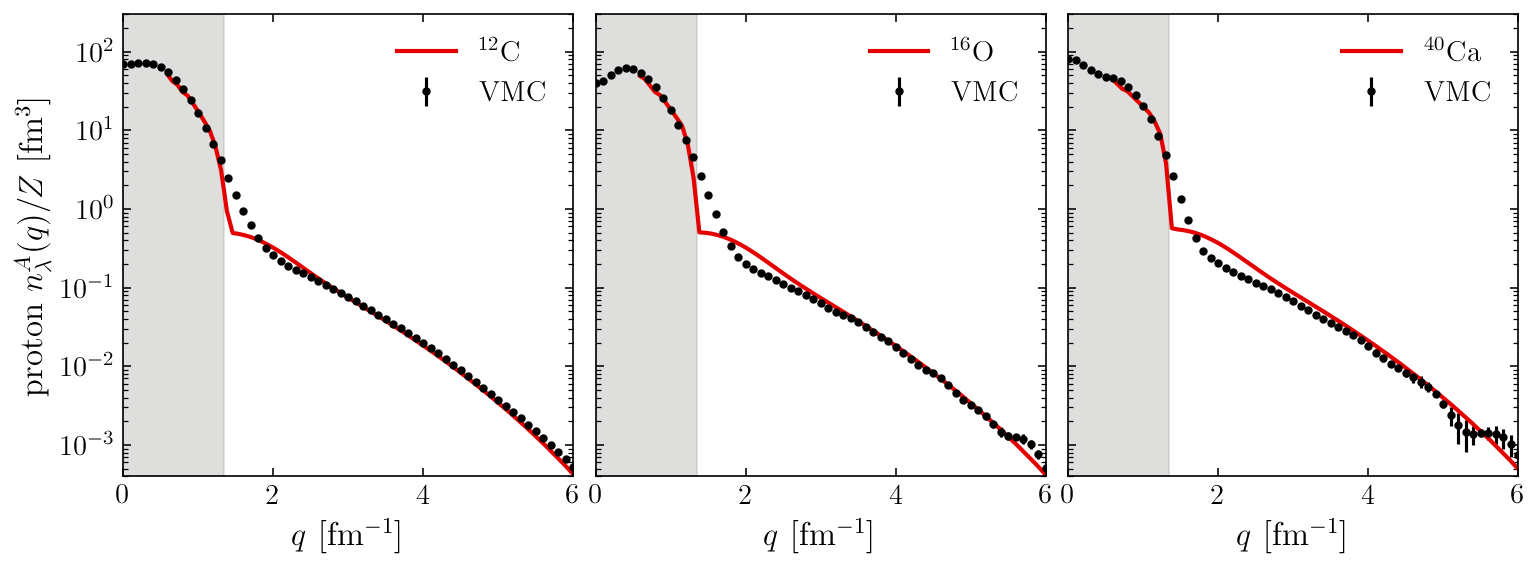

In [11]:
multiple_proton_momentum_distributions(nuclei, kvnn, save=True)

## Pair momentum distribution ratios

## SRC scaling factors $a_2$